In order to execute this file, one has to place it in the same directory as cli.py.

In [1]:
import gpboost as gpb
import numpy as np
import time
import pandas as pd
import sqlite3
import shap
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import logging
import os
# Own modules
from utils import config, io, models
from utils import io_aux_train as training
from utils import io_aux_test as testing

In [2]:
X = io.retrieve_clean_dataset(database_path=config.DATABASE_PATH, 
                              exclude_list=config.exclude_list, 
                              PREDICTED_INDICATOR=config.PREDICTED_INDICATOR)

In [3]:
def score_prediction(bst, X_train, y_train, groups_train,
                     random_effects=True):
    """
    Scores the predictions of a trained Booster model.
    As metrics, rms and r^2 value are used
    Parameters
    ----------

    Returns
    -------"""
    logging.info('Evaluating metrics of predictions of the model')
    y = np.concatenate(y_train.to_numpy(), axis=0)
    non_nan_indices = np.where(np.logical_not(np.isnan(y)))
    y = y[non_nan_indices]
    
    pred = bst.predict(data=X_train, group_data_pred=groups_train)
    if random_effects == True:
        y_pred = pred['fixed_effect'] + pred['random_effect_mean'] 
    else:
        y_pred = pred
    y_pred = y_pred[non_nan_indices]
    rms = mean_squared_error(y, y_pred, squared=False) 
    #rsquared
    y_mean = y.mean()
    SS_tot = np.sum((y - y_mean)**2)
    SS_res = np.sum((y-y_pred)**2)
    rsquared = 1 - SS_res/SS_tot
    return rms, rsquared
    

In [4]:
X = io.retrieve_clean_dataset(database_path=config.DATABASE_PATH,
                              exclude_list=config.exclude_list,
                              PREDICTED_INDICATOR=config.PREDICTED_INDICATOR)
X.columns = X.columns.str.replace(".", "_")
X = X.reset_index(drop=True)
pred_ind = config.PREDICTED_INDICATOR.replace(".", "_")
(X_train, y_train,
 data_train,
 groups_train) = training.retrieve_training_dataset(X,
                                                    predicted_indicator=pred_ind)
(gp_model,
 params,
 opt_num_boost_rounds) = training.get_booster_model(data_train,
                                                    groups_train)
bst = gpb.train(params=params,
                train_set=data_train,
                gp_model=gp_model,
                num_boost_round=opt_num_boost_rounds)

In [5]:
last_indices = [np.argwhere(groups_train == i).max()
                for i in range(len(np.unique(groups_train)))]  # 2011 indices
pred_random_effects = bst.predict(data=X_train, group_data_pred=groups_train)
y_pred_random_effects = pred_random_effects['fixed_effect'] + \
                        pred_random_effects['random_effect_mean']
bst.save_model("classic_GBM_model", num_iteration=opt_num_boost_rounds)
bst_classic_GBM = gpb.Booster(model_file='classic_GBM_model')
y_pred_classic_gbm = bst_classic_GBM.predict(data=X_train,
                                             group_data_pred=groups_train)

For panel data, the form of data that we have in our database, typically data scientists apply Gradient Tree Boosting models. In the following, we will compare the prediction of our model with of a Gradient Tree Boosting, combined with random effects and the prediction of a classic Gradient Tree Boosting method with the real GPD growth data of 2010. 

In [6]:
y_pred_random_effects[last_indices[40:50]]  # sample of our prediction for 2011

array([3.91430927, 1.86278729, 2.55782844, 4.67902558, 2.45651987,
       0.30747763, 0.32745849, 2.35970018, 1.39343873, 3.18722965])

In [7]:
y_pred_classic_gbm[last_indices[40:50]]  # classic gbm prediction

array([3.25315779, 2.36519262, 1.88767941, 3.77132236, 2.55381224,
       1.95404997, 1.95404997, 1.92958383, 2.54817339, 3.71255397])

In [8]:
X_test, group_test = testing.retrieve_test_data(X, bst, 2011)
pd_gdp_growth_2010 = X_test["NY_GDP_MKTP_KD_ZG"]
gdp_growth_2010 = pd_gdp_growth_2010.to_numpy()
gdp_growth_2010[last_indices[40:50]]  # real data

array([0.40026686, 6.65052052, 2.73162042, 4.11682806,        nan,
              nan, 3.62071524, 2.71095557, 1.0823154 , 5.79996262])

In [9]:
non_nan_indices = np.where(np.logical_not(np.isnan(gdp_growth_2010)))

From a sample of the data compared to the predictions we cannot really appreciate the difference. To quantify the quality of both models we can calculate the mean squared error (mse) and the $r^2$ value of the predictions. The mse measures the error of the model in comparison to the real values. Thus, the higher, the less accurate is the model. The $r^2$ value gives the proportion of the variance (the deviation) of the response variable (GPD growth) that is predictable from all the other variables used by the model. So that a high value represents a good prediction. 

In [10]:
rms, rsquared = score_prediction(bst, X_train, y_train, groups_train)

In [11]:
bst.save_model("classic_GBM_model", num_iteration=opt_num_boost_rounds)
bst_classic_GBM = gpb.Booster(model_file='classic_GBM_model')
(rms_classic_GBM,
 rsquared_classic_GBM) = (score_prediction(bst_classic_GBM,
                                           X_train,
                                           y_train,
                                           groups_train,
                                           random_effects=False))

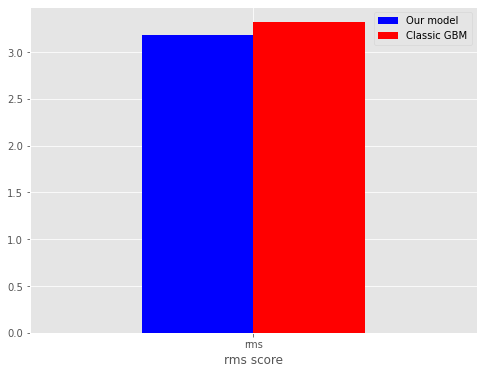

In [12]:
value_df = pd.DataFrame([[rms, rms_classic_GBM, 'rms']],
                        columns=["Our model", "Classic GBM", "rms score"])

plt.style.use('ggplot')

f, ax = plt.subplots(figsize=(8, 6))

value_df.plot(kind='bar', x="rms score",
              sharex=True, ax=ax, rot=0, color=['b', 'r'])
ax.set_xlabel("rms score")
ax.spines["bottom"].set_visible(True)
plt.legend()
plt.show()

A "perfect" model would have a rms score of 0.

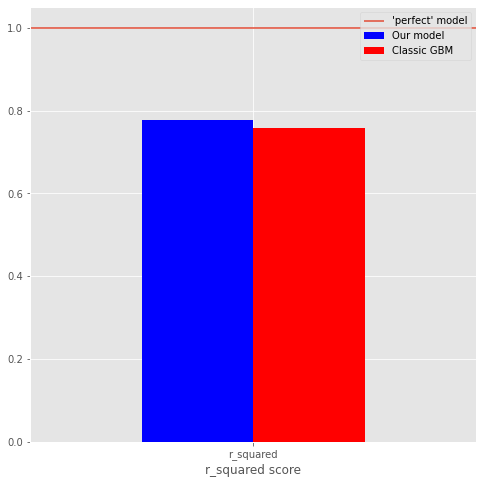

In [13]:
value_df = pd.DataFrame([[rsquared, rsquared_classic_GBM, 'r_squared']],
                        columns=["Our model", "Classic GBM", "r_squared"])

plt.style.use('ggplot')

f, ax = plt.subplots(figsize=(8, 8))

plt.hlines(1, -1, 1, label="'perfect' model")
value_df.plot(kind='bar', x="r_squared",
              sharex=True, ax=ax, rot=0, color=['b', 'r'])
ax.set_xlabel("r_squared score")
ax.spines["bottom"].set_visible(True)
plt.legend()
plt.show()

We can see that our models overpass the classic GBM models in quality.

In [14]:
#Text describing the things below when having final database X
#Text saying that shap analysis couldnt be done 

In [15]:
X = X.set_index("Time")
X["Time"] = X.index.get_level_values(0)
X_test, group_test = testing.retrieve_test_data(X, bst, 2010)
y_pred = testing.predict(X_test, bst, group_test)
y_pred[0:10]  # sample of the first ten countries of our predictions for 2010

array([-3.54256997, -1.10260361, 13.10671188,  0.63417895,  2.89352359,
       -1.52580726,  1.35366724, -7.44128867,  0.10570773, -5.56670227])

In [16]:
X = X.set_index("Time")
X["Time"] = X.index.get_level_values(0)
X_test, group_test = testing.retrieve_test_data(X, bst, 2011)
y_pred = testing.predict(X_test, bst, group_test)
y_pred[0:10]  # sample of the first ten countries of our predictions for 2011

array([ 0.36846558, -2.06556734,  4.94130797,  0.63417895,  3.04989297,
        2.26220764,  6.20910917,  1.45367944,  0.10343272, -2.65993188])

In [17]:
X = X.set_index("Time")
X["Time"] = X.index.get_level_values(0)
X_test, group_test = testing.retrieve_test_data(X, bst, 2012)
y_pred = testing.predict(X_test, bst, group_test)
y_pred[0:10]

array([ 0.36846558, -0.10046106,  3.53476866,  0.63417895,  2.6576077 ,
        2.67387632,  4.83172948,  1.02688504, -0.13670609, -0.80311388])

In [18]:
X = X.set_index("Time")
X["Time"] = X.index.get_level_values(0)
X_test, group_test = testing.retrieve_test_data(X, bst, 2013)
y_pred = testing.predict(X_test, bst, group_test)
y_pred[0:10]

array([ 0.36846558,  1.07041128,  2.72852927,  0.63417895,  2.31808177,
        2.89981347,  4.31993088,  0.56414072, -0.36773676,  0.36361939])

In [19]:
X = X.set_index("Time")
X["Time"] = X.index.get_level_values(0)
X_test, group_test = testing.retrieve_test_data(X, bst, 2015)
y_pred = testing.predict(X_test, bst, group_test)
y_pred[0:10]

array([ 0.36846558,  1.90789922,  1.81878352,  0.63417895,  2.07111004,
        3.15816839,  3.61315522,  0.56414072, -0.48489427,  1.87900326])

In [20]:
X = X.set_index("Time")
X["Time"] = X.index.get_level_values(0)
X_test, group_test = testing.retrieve_test_data(X, bst, 2020)
y_pred = testing.predict(X_test, bst, group_test)
y_pred[0:10]

array([ 0.36846558,  2.02077716,  0.80325237,  0.63417895,  2.07111004,
        3.33082126,  3.5136915 ,  0.56414072, -0.48489427,  2.39190052])

In each block of printed values above we can see the predictions for the 10 first countries in alphabetic order for a concrete year. The values for only 10 countries were printed for the sake of readability.
As we can see from the values, the prediction for each year becomes more and more similar to the one of the previous year. Thus, our model is more precise for years that are not too much greater than 2010. But our model can still predict an arbitrary big year.